In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns
import matplotlib.font_manager as fm




## Font and format

In [2]:
import warnings
# 忽略所有警告
warnings.filterwarnings("ignore")
font_path = os.path.expanduser('~/.fonts/arial.ttf')
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Arial'
fonts = [f.name for f in matplotlib.font_manager.fontManager.ttflist]
print(sorted(set(fonts)))
fonts = [f.name for f in fm.fontManager.ttflist]
arial_fonts = [f for f in fonts if 'Arial' in f]
print("Available Arial fonts:", arial_fonts)
plt.rcParams['font.family'] = 'Arial'
# 设置pandas显示的最大列数
pd.set_option('display.max_columns', None)
# 设置某一行的最大字符显示长度，防止某列字符过长时被截断，可以根据需要调整数字
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.precision', 2)  # 设置小数点显示精度
# # 设置全局显示选项，保留2位小数
# pd.options.display.float_format = "{:.6f}".format

['Arial', 'DejaVu Sans', 'DejaVu Sans Display', 'DejaVu Sans Mono', 'DejaVu Serif', 'DejaVu Serif Display', 'Inconsolata', 'STIXGeneral', 'STIXNonUnicode', 'STIXSizeFiveSym', 'STIXSizeFourSym', 'STIXSizeOneSym', 'STIXSizeThreeSym', 'STIXSizeTwoSym', 'Source Code Pro', 'Ubuntu', 'Ubuntu Condensed', 'Ubuntu Mono', 'cmb10', 'cmex10', 'cmmi10', 'cmr10', 'cmss10', 'cmsy10', 'cmtt10']
Available Arial fonts: ['Arial']


## Reading data

In [ ]:
# sbufferjoinhousefhsz=gpd.read_file('../Data/Processed/fhszvegechangeanddensityclass.gpkg')before 2025/2/23

In [3]:
sbufferjoinhousefhsz=gpd.read_parquet('../Data/Processed/buildings/buildingswithtreecover/building_addhousetypes_treecover.parquet')
sbufferjoinhousefhsz.columns

Index(['FID_Califo', 'WUICLASS_2', 'WUIFLAG202', 'GEOID', 'FHSZ_7Clas',
       'COUNTYFP', 'geometry', 'newhouse', 'cluster15', 'cluster50',
       'allhousecountbybuffer50', 'allhousecountbybuffer15', 'housingclass',
       'areaall2010', 'areabare2010', 'areagrass2010', 'areatree2010',
       'areaurban2010', 'cluster2010', 'cluster2022', 'areaall2022',
       'areatree2022', 'allhcount', 'newhcount', 'treeratio2010',
       'treeratio2022', 'treeratiochange', 'COUNTY'],
      dtype='object')

## Overall tree cover change, not dividing by building types

In [7]:
def treechangebycounty(df):
    
    treeratiochange=df.query('newhouse==0').groupby(['COUNTY'])['treeratiochange'].mean().to_frame('Average_treeratiochange(%)').reset_index()
    treeratio2010=df.query('newhouse==0').groupby(['COUNTY'])['treeratio2010'].mean().to_frame('treeratio2010(%)').reset_index()
    treeratio2022=df.query('newhouse==0').groupby(['COUNTY'])['treeratio2022'].mean().to_frame('treeratio2022(%)').reset_index()
    
    treerise=df.query('newhouse==0 and treeratiochange>0').groupby(['COUNTY']).size().to_frame('treerise_count').reset_index()
    oldall=df.query('newhouse==0').groupby(['COUNTY']).size().to_frame('oldbuildings(units)').reset_index()
    
    treechange=oldall.merge(treeratio2010,on=['COUNTY'],how='left')\
    .merge(treeratio2022,on=['COUNTY'],how='left')\
    .merge(treeratiochange,on=['COUNTY'],how='left')\
    .merge(treerise,on=['COUNTY'],how='left')\
    
    
    treechange.iloc[:,2:4]=treechange.iloc[:,2:4]*100
    treechange['ratio_of_buildingswithincreasedtree(%)']=100*treechange['treerise_count']/treechange['oldbuildings(units)']
    ## for all countries
    total_treeratio2010=100*df.query('newhouse==0')['treeratio2010'].mean()
    total_treeratio2022=100*df.query('newhouse==0')['treeratio2022'].mean()
    total_treeratiochange=df.query('newhouse==0')['treeratiochange'].mean()
    total_oldbuildings,total_buildingstreerise=len(df.query('newhouse==0')),len(df.query('newhouse==0 and treeratiochange>0'))
    total_treeriseratio=100*total_buildingstreerise/total_oldbuildings
    treechange.loc[len(treechange)]=['Total',total_oldbuildings,total_treeratio2010,total_treeratio2022,total_treeratiochange,total_buildingstreerise,total_treeriseratio]
    print(treechange)
treechangebycounty(sbufferjoinhousefhsz)

            COUNTY  oldbuildings(units)  treeratio2010(%)  treeratio2022(%)  \
0             Kern                28678            13.820             9.971   
1      Los Angeles               181044            14.655            18.231   
2           Orange                52549            11.253            18.126   
3        Riverside                86233             7.042            11.010   
4   San Bernardino                92459            10.889            17.937   
5        San Diego               159946            10.313            21.830   
6  San Luis Obispo                28737            18.208            17.154   
7    Santa Barbara                21130            24.214            26.692   
8          Ventura                54730            16.639            21.379   
9            Total               705506            12.544            18.236   

   Average_treeratiochange(%)  treerise_count  \
0                      -0.038            8433   
1                       0.036   

## Building types distribution of old buildings and old buildings near new

In [16]:
def housetypebycounty(df,tag):
    if tag=='old':
        treechange = df.query('newhouse==0').groupby(['COUNTY', 'housingclass']).size().unstack(fill_value = 0)\
        .add_prefix('old_').reset_index()
    if tag=='oldwithnew':
        treechange = df.query('newhouse==0 and newhcount>0').groupby(['COUNTY', 'housingclass']).size().unstack(fill_value = 0)\
        .add_prefix('oldwithnew_').reset_index()
    
    house_type_columns = [col for col in treechange.columns if col != 'COUNTY']
    # create a dict
    totals = {col: treechange[col].sum() for col in house_type_columns}
    print(totals)
    grand_total = sum(totals.values())
    
    # The ** operator is used to unpack the contents of a dictionary,**totals unpack the key into columns name, value into the value of this column
    total_row = pd.DataFrame({
        'COUNTY': ['Total'],  
        **totals
    })
    
    print(total_row)
    # Add ratio columns and calculate ratios
    for col in house_type_columns:
        total_count = totals[col]
        if total_count == 0:
            treechange[col + '_ratio'] = 0
            total_row[col + '_ratio'] = 0
        else:
            treechange[col + '_ratio'] = 100 * treechange[col] / total_count
            # For total row, ratio is column total / grand total
            total_row[col + '_ratio'] = 100 * total_count / grand_total
    
    # Combine original dataframe with total row
    treechange = pd.concat([treechange, total_row], ignore_index=True)
    return treechange
old_countyhousetype=housetypebycounty(sbufferjoinhousefhsz,'old')
oldwithnew_countyhousetype=housetypebycounty(sbufferjoinhousefhsz,'oldwithnew')
housetypesbycounty=old_countyhousetype.merge(oldwithnew_countyhousetype,on=['COUNTY'],how='left')

{'old_dense': 149208, 'old_isolated': 26254, 'old_scattered': 74235, 'old_very dense': 455809}
  COUNTY  old_dense  old_isolated  old_scattered  old_very dense
0  Total     149208         26254          74235          455809
{'oldwithnew_dense': 5491, 'oldwithnew_isolated': 239, 'oldwithnew_scattered': 2669, 'oldwithnew_very dense': 79131}
  COUNTY  oldwithnew_dense  oldwithnew_isolated  oldwithnew_scattered  \
0  Total              5491                  239                  2669   

   oldwithnew_very dense  
0                  79131  


In [17]:
housetypesbycounty

,COUNTY,old_dense,old_isolated,old_scattered,old_very dense,old_dense_ratio,old_isolated_ratio,old_scattered_ratio,old_very dense_ratio,oldwithnew_dense,oldwithnew_isolated,oldwithnew_scattered,oldwithnew_very dense,oldwithnew_dense_ratio,oldwithnew_isolated_ratio,oldwithnew_scattered_ratio,oldwithnew_very dense_ratio
0,Kern,10303,1845,4239,12291,6.91,7.03,5.71,2.70,177,1,49,1537,3.22,0.42,1.84,1.94
1,Los Angeles,20987,2422,8603,149032,14.07,9.23,11.59,32.70,904,34,446,36375,16.46,14.23,16.71,45.97
2,Orange,2941,175,1140,48293,1.97,0.67,1.54,10.60,153,3,9,6661,2.79,1.26,0.34,8.42
3,Riverside,23651,5300,16563,40719,15.85,20.19,22.31,8.93,709,46,539,5002,12.91,19.25,20.19,6.32
4,San Bernardino,26917,3263,10548,51731,18.04,12.43,14.21,11.35,862,31,367,10292,15.70,12.97,13.75,13.01
5,San Diego,43268,7033,18464,91181,29.00,26.79,24.87,20.00,2022,72,877,11316,36.82,30.13,32.86,14.30
6,San Luis Obispo,7379,3986,8325,9047,4.95,15.18,11.21,1.98,38,7,68,1212,0.69,2.93,2.55,1.53
7,Santa Barbara,6988,1242,3088,9812,4.68,4.73,4.16,2.15,381,32,176,1384,6.94,13.39,6.59,1.75
8,Ventura,6774,988,3265,43703,4.54,3.76,4.40,9.59,245,13,138,5352,4.46,5.44,5.17,6.76
9,Total,149208,26254,74235,455809,21.15,3.72,10.52,64.61,5491,239,2669,79131,6.27,0.27,3.05,90.40


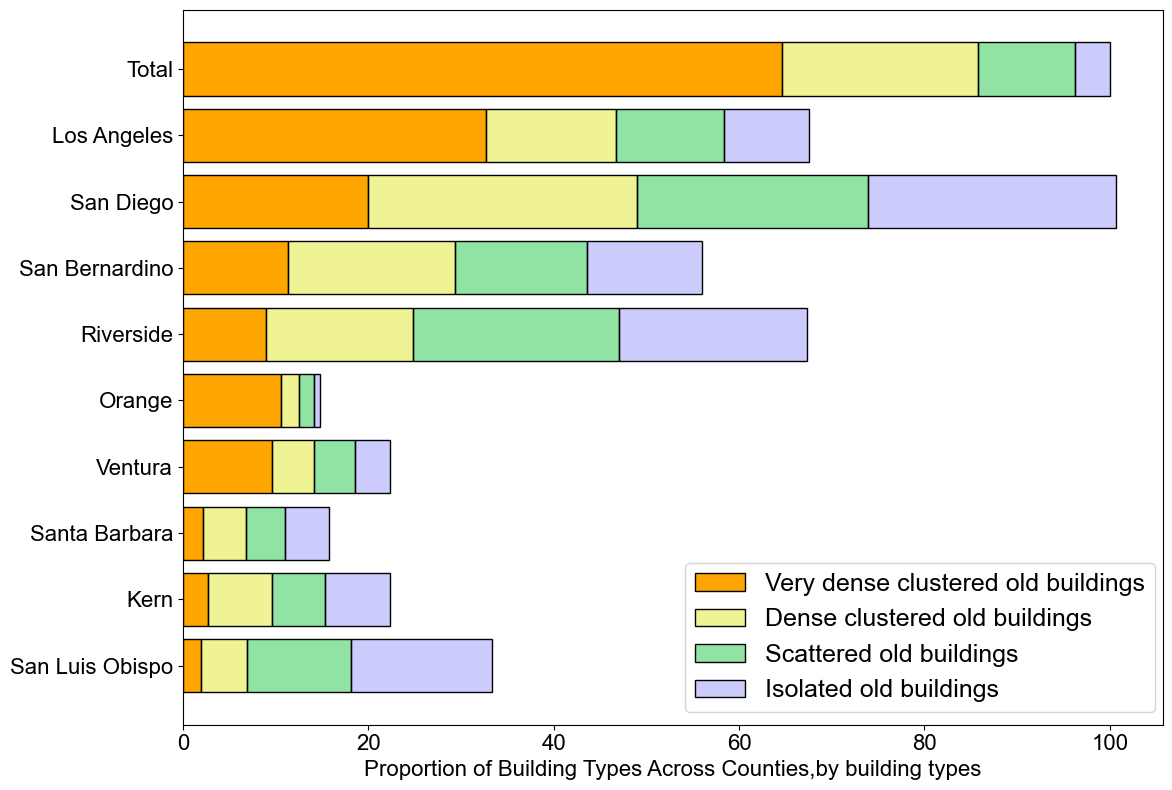

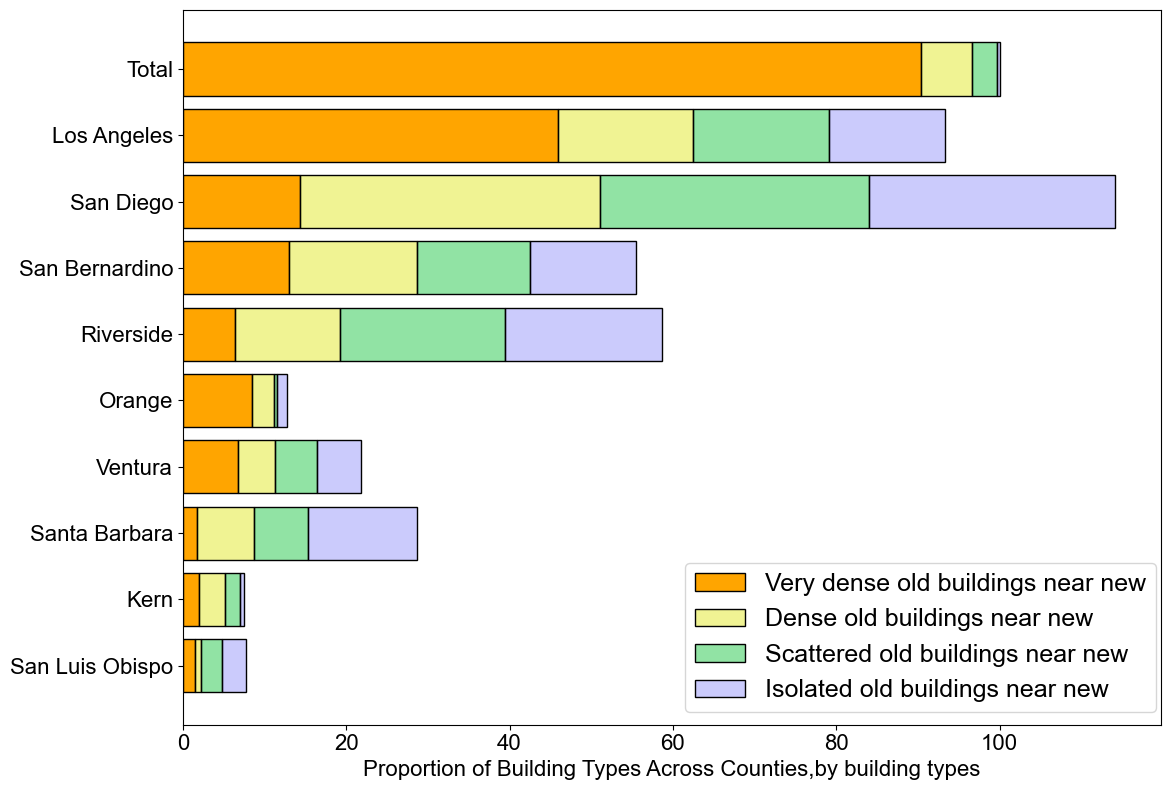

In [18]:
def plot_county_ratios(df,tag):
    
    colors = ['Orange', '#e3e92880', '#25c94b80', '#9999fb80']
    fig, ax = plt.subplots(figsize=(12,8))
    if tag=='oldwithnew':
        ratio_columns = ['oldwithnew_very dense_ratio', 'oldwithnew_dense_ratio', 
                        'oldwithnew_scattered_ratio', 'oldwithnew_isolated_ratio']
        
        legend_names = ['Very dense old buildings near new', 'Dense old buildings near new',
                    'Scattered old buildings near new', 'Isolated old buildings near new']
        
        df_sorted = df.sort_values('oldwithnew_very dense_ratio', ascending=True)
    else:
        ratio_columns = ['old_very dense_ratio', 'old_dense_ratio', 
                        'old_scattered_ratio', 'old_isolated_ratio']
        
        legend_names = ['Very dense clustered old buildings', 'Dense clustered old buildings',
                    'Scattered old buildings', 'Isolated old buildings']
        
        df_sorted = df.sort_values('old_very dense_ratio', ascending=True)
        
    # 获取当前排序后的county列表
    county_order = df_sorted['COUNTY'].tolist()
    
    # 找到Orange和Riverside的位置
    orange_idx = county_order.index('Orange')
    riverside_idx = county_order.index('Riverside')
    # 调整顺序
    county_order.remove('Riverside')
    county_order.insert(orange_idx, 'Riverside')
    
    orange_idx = county_order.index('Santa Barbara')
    riverside_idx = county_order.index('Kern')
    # 调整顺序
    county_order.remove('Kern')
    county_order.insert(orange_idx, 'Kern')
    # 根据新顺序重排数据框
    df = df_sorted.set_index('COUNTY').loc[county_order].reset_index()
    left = np.zeros(len(df))
    for ratio, color, legend in zip(ratio_columns, colors, legend_names):
        ax.barh(df['COUNTY'], df[ratio], left=left, color=color, edgecolor='black', linewidth=1,
                label=legend)
        left += df[ratio]
    
    ax.set_xlabel('Proportion of Building Types Across Counties,by building types',fontsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.tick_params(axis='x', labelsize=16)
    ax.legend(loc='lower left', bbox_to_anchor=(0.5, 0),fontsize=18)
    plt.tight_layout() 
    return fig, ax

fig, ax = plot_county_ratios(housetypesbycounty,'old')
fig, ax = plot_county_ratios(housetypesbycounty,'oldwithnew')
plt.show()

## Building footprints(old&new) distribution across countries

In [19]:
def building_byoldandnew(df):
    oldcounts=df.query('newhouse==0').groupby(['COUNTY']).size().to_frame('Old buildings (units)').reset_index()
    oldwithnew=df.query('newhouse==0 and (newhcount>0)').groupby(['COUNTY']).size().to_frame('Old buildings with new (units)').reset_index()
    newnearold=df.query('newhouse==1 and (allhcount!=newhcount)').groupby(['COUNTY']).size().to_frame('New buildings near old (units)').reset_index()
    newcounts=df.query('newhouse==1').groupby(['COUNTY']).size().to_frame('New buildings (units)').reset_index()
    oldnew=oldcounts.merge(newcounts,on=['COUNTY'],how='left').merge(newnearold,on=['COUNTY'],how='left').merge(oldwithnew,on=['COUNTY'],how='left')
    
    # Total row
    sums = oldnew.sum(numeric_only=True)  
    # print(sums)
    new_row = {}
    for column in oldnew.columns:
        if column == 'new-to-old-proximity ratio':
            new_row[column] = None 
        elif column=='COUNTY':
            new_row[column] = 'Total'
        elif column in oldnew.columns:
            new_row[column] = sums[column] if column in sums else None
    oldnew = pd.concat([oldnew, pd.DataFrame([new_row])], ignore_index=True)
    # Add column
    oldnew['new-to-old-proximity ratio']=oldnew['New buildings near old (units)']/oldnew['Old buildings with new (units)']
    print(oldnew)


building_byoldandnew(sbufferjoinhousefhsz)

            COUNTY  Old buildings (units)  New buildings (units)  \
0             Kern                  28678                    250   
1      Los Angeles                 181044                   7319   
2           Orange                  52549                   2574   
3        Riverside                  86233                   6638   
4   San Bernardino                  92459                   5249   
5        San Diego                 159946                  13604   
6  San Luis Obispo                  28737                    139   
7    Santa Barbara                  21130                   1230   
8          Ventura                  54730                   1872   
9            Total                 705506                  38875   

   New buildings near old (units)  Old buildings with new (units)  \
0                             177                            1764   
1                            3515                           37759   
2                             272           

## Building ratio under different tree rise levels

### Old buildinngs

In [20]:

df0=pd.DataFrame(columns=['COUNTYFP','treeriseratio',
                        'treeriseratio_verydense','treeriseratio_dense','treeriseratio_scattered','treeriseratio_isolated'])

def calvege(dfa,ratio,fp):
    if fp=='All':
        dfall1=dfa
    
    else:
        dfall1 = dfa[dfa['COUNTYFP'].isin(fp)] 
    if ratio>=0:
        treerise = dfall1[dfall1['treeratiochange']>ratio]
    if ratio==-0.001:
        treerise = dfall1[dfall1['treeratiochange']<0]
    if ratio<0:
        treerise = dfall1[dfall1['treeratiochange']<ratio]
    treeriseratio = 100*len(treerise) / len(dfall1)
    return treeriseratio


            
def calculate_ratios_by_counties(h_verydense,h_dense,h_scattered,h_isolated,treeriseratio,fp):

    treeriseratio_verydense=calvege(h_verydense,treeriseratio,fp)
    treeriseratio_dense=calvege(h_dense,treeriseratio,fp)
    treeriseratio_scattered=calvege(h_scattered,treeriseratio,fp)
    treeriseratio_isolated=calvege(h_isolated,treeriseratio,fp)
  
    df0.loc[len(df0)] = [fp,treeriseratio,treeriseratio_verydense,treeriseratio_dense,treeriseratio_scattered,treeriseratio_isolated]

       

def calhousingratiobydensity(df,fps):
    # fps=['065','073','071','037']
    for fp in fps:      
        for ratio in [0,0.05,0.1,0.15,0.2,0.25,0.3]:
            calculate_ratios_by_counties(
            df.query('housingclass=="very dense"'),
            df.query('housingclass=="dense"'),
            df.query('housingclass=="scattered"'),
            df.query('housingclass=="isolated"'),
            ratio,fp)
# df0.to_csv('../statistic/vegechange/urbandensityhouseratiorise.csv')
fps = ['All',["083","111"],["059"],["073"],["065","071"],['079'],['029'],['037']] 
calhousingratiobydensity(sbufferjoinhousefhsz.query('newhouse==0'),fps)

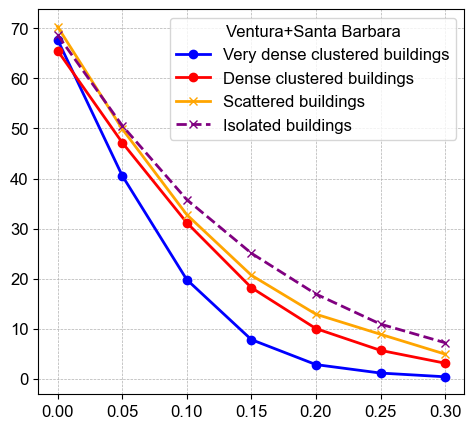

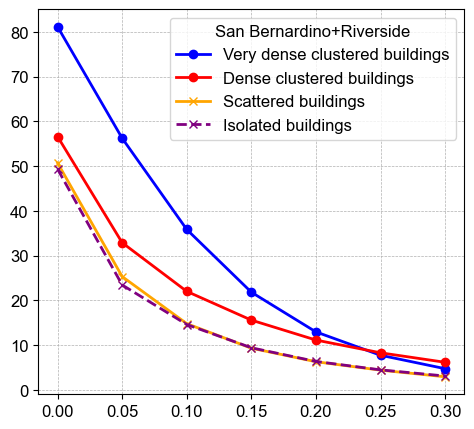

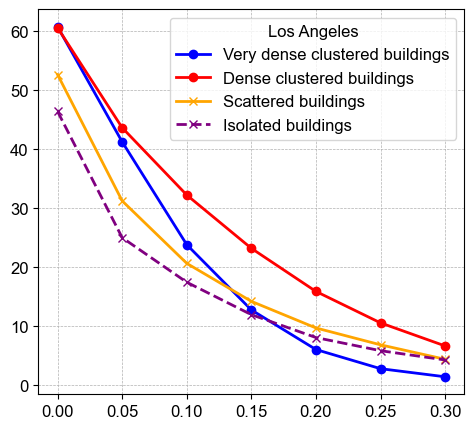

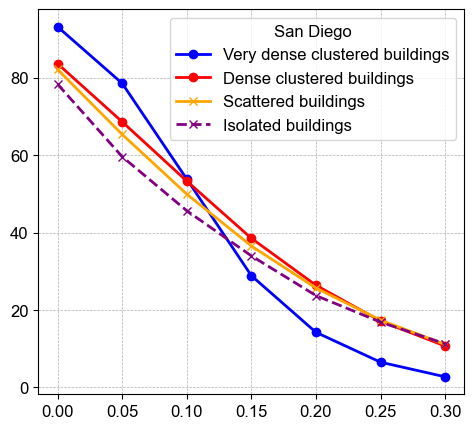

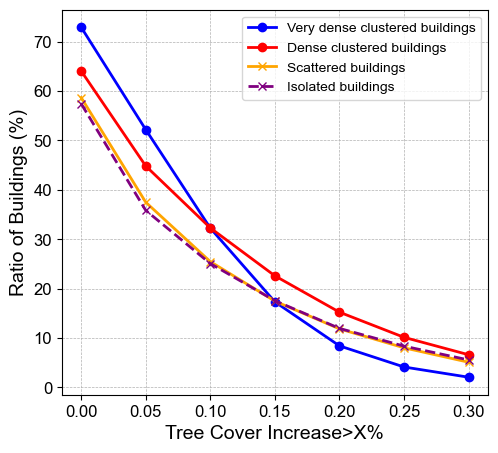

In [52]:
def plot_treerisebylevel(countryname='None',fp='None'):
    fig, ax = plt.subplots(1, 1, figsize=(5.5,5))
    df=df0.query('COUNTYFP in @fp')
    df.plot('treeriseratio', 'treeriseratio_verydense', ax=ax, linestyle='-', marker='o', color='blue', linewidth=2, label='Very dense clustered buildings')
    df.plot('treeriseratio', 'treeriseratio_dense', ax=ax, linestyle='-', marker='o', color='red', linewidth=2, label='Dense clustered buildings')
    df.plot('treeriseratio', 'treeriseratio_scattered', ax=ax, linestyle='-', marker='x', color='orange', linewidth=2, label='Scattered buildings ')
    df.plot('treeriseratio', 'treeriseratio_isolated', ax=ax, linestyle='--', marker='x', color='purple', linewidth=2, label='Isolated buildings')

 
    if fp=='All':
        ax.set_xlabel('Tree Cover Increase>X%', fontsize=14,weight='bold')
        ax.set_ylabel('Ratio of Buildings (%)', fontsize=14,weight='bold')
        
    else:
        ax.set_xlabel('')
        ax.legend(fontsize=12,loc='best',title=countryname,title_fontsize=12,alignment='center') 


    ax.grid(True, linestyle='--', linewidth=0.5)
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.show()

plot_treerisebylevel('Ventura+Santa Barbara',[["083","111"]])
plot_treerisebylevel('San Bernardino+Riverside',[["065","071"]])
plot_treerisebylevel('Los Angeles',[["037"]])
plot_treerisebylevel('San Diego',[["073"]])
plot_treerisebylevel('None',"All")


### Old buildings near new

In [ ]:

df0=pd.DataFrame(columns=['COUNTYFP','treeriseratio',
                          'treeriseratio_verydense_nearnew','treeriseratio_verydense_nonear',
                           'treeriseratio_dense_nearnew','treeriseratio_dense_nonear',
                          'treeriseratio_scattered_nearnew','treeriseratio_scattered_nonear'])

def calvege(dfa,ratio,fp):
    if fp=='All':
        dfall1=dfa
    
    else:
        dfall1 = dfa[dfa['COUNTYFP'] ==fp] 
    # print(len(dfall1))
    if ratio>=0:
        treerise = dfall1[dfall1['treeratiochange']>ratio]
    if ratio<0:
        treerise = dfall1[dfall1['treeratiochange']<ratio]
    treeriseratio = 100*len(treerise) / len(dfall1)
    return treeriseratio


               

               
def calculate_ratios_by_counties(df,treeriseratio,fp):
    h_verydense_nearnew=df.query('newhcount>0 and housingclass=="very dense"')
    h_verydense_nonew=df.query('newhcount==0 and housingclass=="very dense"')
    h_dense_nearnew=df.query('newhcount>0 and housingclass=="dense"')
    h_dense_nonew=df.query('newhcount==0 and housingclass=="dense"')
    h_scattered_nearnew=df.query('newhcount>0 and housingclass=="scattered"')
    h_scattered_nonew=df.query('newhcount==0 and housingclass=="scattered"')

    treeriseratio_verydense_nearnew=calvege(h_verydense_nearnew,treeriseratio,fp)
    treeriseratio_verydense_nonew=calvege(h_verydense_nonew,treeriseratio,fp)
    treeriseratio_dense_nearnew=calvege(h_dense_nearnew,treeriseratio,fp)
    treeriseratio_dense_nonew=calvege(h_dense_nonew,treeriseratio,fp)
    treeriseratio_scattered_nearnew=calvege(h_scattered_nearnew,treeriseratio,fp)
    treeriseratio_scattered_nonew=calvege(h_scattered_nonew,treeriseratio,fp)
    
    df0.loc[len(df0)] = [fp,treeriseratio,
                         treeriseratio_verydense_nearnew,treeriseratio_verydense_nonew,
                         treeriseratio_dense_nearnew,treeriseratio_dense_nonew,
                         treeriseratio_scattered_nearnew,treeriseratio_scattered_nonew
                         ]


    


fps = ["All","037","111","059","073","065","071","029","079","083"] 
def calhousingratiobydensity(df):
    for fp in fps:
        for ratio in [0,0.05,0.1,0.15,0.2,0.25,0.3]:
            calculate_ratios_by_counties(df,ratio,fp)
# df0.to_csv('../statistic/vegechange/urbandensityhouseratiorise.csv')
calhousingratiobydensity(sbufferjoinhousefhsz.query('newhouse==0'))

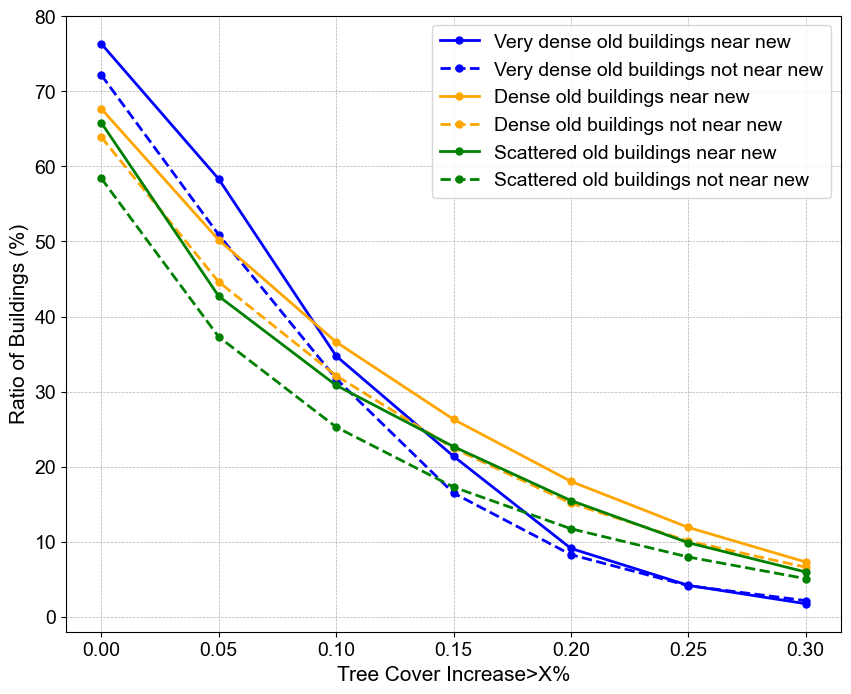

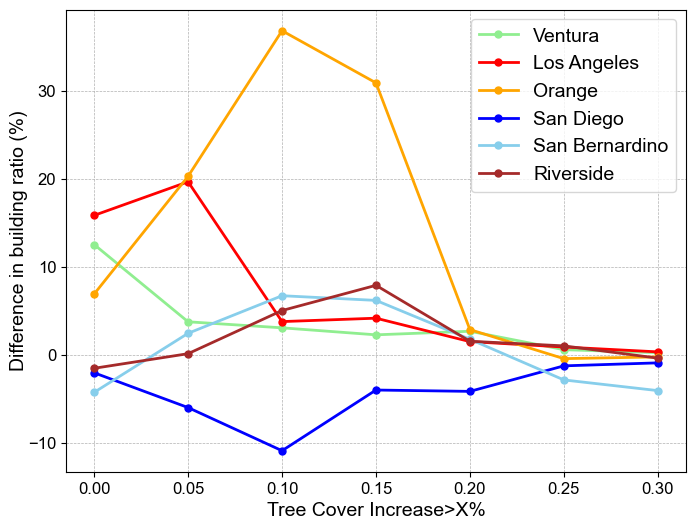

In [20]:
def plot_treerise_oldnearnew(tag='All'):
    if tag!='All':
        fig, ax = plt.subplots(1, 1, figsize=(8,6))
        counties = ['111','037','059','073','071','065']
        labels = ['Ventura', 'Los Angeles', 'Orange','San Diego', 'San Bernardino','Riverside'] 
        colors = ['lightgreen', 'red', 'orange','blue', 'skyblue', 'brown', 'pink']
        for county, label,color in zip(counties,labels, colors):
            df_county = df0.query(f'treeriseratio>=0 and COUNTYFP == "{county}"')
            df_county['treeriseratio_verydense_diff'] = df_county['treeriseratio_verydense_nearnew']\
            - df_county['treeriseratio_verydense_nonear']

            df_county.plot('treeriseratio', 'treeriseratio_verydense_diff', 
                        ax=ax,
                        linestyle='-', 
                        marker='o',
                        markersize=5,
                        color=color,
                        linewidth=2,
                        label=label,
                        fontsize=14)
            plt.xlabel('Tree Cover Increase>X%', fontsize=14,weight='bold') #Tree cover change ratio(%)
            plt.ylabel('Difference in building ratio (%)', fontsize=14,weight='bold',labelpad=0)


            plt.grid(True, linestyle='--', linewidth=0.5)
            plt.legend(fontsize=14,loc='upper right')
            plt.tick_params(axis='both', which='major', labelsize=12)
        plt.show()
    else:
        fig, ax = plt.subplots(1, 1, figsize=(10,8))
        width=2
        
        df0.query('treeriseratio>=0 and COUNTYFP == "All"').plot('treeriseratio', 'treeriseratio_verydense_nearnew', ax=ax, linestyle='-', marker='o', markersize=5, color='blue', linewidth=width, label='Very dense old buildings near new',fontsize=14)
        df0.query('treeriseratio>=0 and COUNTYFP == "All"').plot('treeriseratio', 'treeriseratio_verydense_nonear', ax=ax, linestyle='--', marker='o', markersize=5,color='blue', linewidth=width, label='Very dense old buildings not near new',fontsize=14)
        df0.query('treeriseratio>=0 and COUNTYFP == "All"').plot('treeriseratio', 'treeriseratio_dense_nearnew', ax=ax, linestyle='-', marker='o', markersize=5,color='orange', linewidth=width, label='Dense old buildings near new',fontsize=14)
        df0.query('treeriseratio>=0 and COUNTYFP == "All"').plot('treeriseratio', 'treeriseratio_dense_nonear', ax=ax, linestyle='--', marker='o', markersize=5,color='orange', linewidth=width, label='Dense old buildings not near new')
        df0.query('treeriseratio>=0 and COUNTYFP == "All"').plot('treeriseratio', 'treeriseratio_scattered_nearnew', ax=ax, linestyle='-', marker='o',markersize=5, color='green', linewidth=width, label='Scattered old buildings near new',fontsize=14)
        df0.query('treeriseratio>=0 and COUNTYFP == "All" ').plot('treeriseratio', 'treeriseratio_scattered_nonear', ax=ax, linestyle='--', marker='o', markersize=5,color='green', linewidth=width, label='Scattered old buildings not near new')
        plt.xlabel('Tree Cover Increase>X%', fontsize=15,weight='bold') #Tree cover change ratio(%)
        plt.ylabel('Ratio of Buildings (%)', fontsize=15,weight='bold')
        plt.grid(True, linestyle='--', linewidth=0.5)
        plt.legend(fontsize=14,loc='upper right')
        plt.tick_params(axis='both', which='major', labelsize=14)
        plt.show()

                        
plot_treerise_oldnearnew('All')
plot_treerise_oldnearnew('Not All')

# Boxplot-tree cover change of  old buildings and old with new

In [22]:


def annotate_pvalue(ax,center1, center2, p_value,tag):
    # Get info about y-axis
    bottom, top = ax.get_ylim()
    yrange = top - bottom
    level = 0
    bar_height = (yrange * 0.08 * level) + top
    bar_tips = bar_height - (yrange * 0.13)

    text_height = bar_height + (yrange * 0.005)

    plt.plot(
            [center1,center1,center2,center2],
            [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k')
    # Determine significance level
    if p_value < 0.001:
        text = '***'
    elif p_value < 0.01:
        text = '**'
    elif p_value < 0.05:
        text = '*'
    else:
        text = 'Non-sig'  # Non-significant
    if text=='Non-sig':
            ax.text((center1 + center2) *0.5, text_height, text, ha='center', va='bottom', color='k',fontsize=12,fontweight='bold')
    
    else:
        # for very dense
        # ax.text((center1 + center2) *0.5, text_height-3, text, ha='center', va='bottom', color='k',fontsize=18,fontweight='bold')
        ax.text((center1 + center2) *0.5, text_height-2, text, ha='center', va='bottom', color='k',fontsize=18,fontweight='bold')
   
    return 0
       

## plot old(all and bycountries) and oldnearnew(all)

In [23]:
def create_singleboxplot(data, pos, color):
    boxprops = dict(linewidth=1.5)
    meanprops = dict(marker='o', markerfacecolor='white', 
                        markeredgecolor='orange', markersize=5)
    box = plt.boxplot(data, positions=[pos],
                         patch_artist=True,
                         showfliers=False,
                         showmeans=True,
                         boxprops=boxprops,
                         medianprops={'color': 'red', 'linewidth': 1},
                         meanprops=meanprops)
    plt.setp(box['boxes'], facecolor=color)
    return box

def create_boxplot(data_dict, add0,figsize=(10, 8),p_values=1,tag='oldnew',nc=2,fp='All'):

    fig, ax = plt.subplots(figsize=figsize)
    boxes = []
    means = []
    if tag=='oldnew':
        positions = [0,0.3,0.7,1,1.4,1.7,2.1,2.4] 
        colors = ['#fe9929', '#fed98e','#b2e2e2', '#e5f5f9','#a1d99b', '#e5f5e0','#bcbddc', '#efedf5']
        for name, data_tuple in data_dict.items():
            for data, pos, color in zip(data_tuple, positions, colors):
                box=create_singleboxplot(data,pos,color)
                means.append(box['means'][0].get_ydata()[0])
                if pos in [0, 0.3]:
                    boxes.append(box)

        custom_palette = {
        'Very Dense old buildings near new': '#fe9929', 
        'Very Dense old buildings not near new': '#fed98e',
        'Dense old buildings near new': '#b2e2e2',  
        'Dense old buildings not near new': '#e5f5f9',  
        'Scattered old buildings near new': '#a1d99b',  
        'Scattered old buildings not near new': '#e5f5e0',  
        'Isloated old buildings near new': '#bcbddc',  #
        'Isloated old buildings not near new': '#efedf5'}
    
        plt.yticks([-40, 0,10, 25, 50],fontsize=20)
        # Add p-values annotations
        for key, value in p_values.items():
            p_val, (idx1, idx2) = value
            if idx1==0:
                center1,center2=positions[0],positions[1]
            if idx1==2:
                center1,center2=positions[2],positions[3]
            if idx1==4:
                center1,center2=positions[4],positions[5]
            if idx1==6:
                center1,center2=positions[6],positions[7]
            annotate_pvalue(ax, center1, center2, p_val,tag)
    
    if tag=='old':
            # Create the boxplots and store mean values
            positions = [0, 0.3,0.6,0.9] 
            colors = ['#fd8d3cCC', '#fed98e','#b2e2e2', '#e5f5f9']
            for name, data_tuple in data_dict.items():
                for data, pos, color in zip(data_tuple, positions, colors):
                    box=create_singleboxplot(data,pos,color)
                    means.append(box['means'][0].get_ydata()[0])
                    if pos in [0, 0.3]:
                        boxes.append(box)
            # Plot the connecting line using the means
            plt.plot(positions, means, marker='o', linestyle='--', color='orange', markersize=1)
            custom_palette = {
            'Very dense clustered buildings': '#fd8d3cCC',  
            'Dense clustered buildings': '#fed98e',   
            'Scattered buildings': '#b2e2e2' ,  #feedde
            'Isolated buildings': '#e5f5f9' }
            ## Add p-values annotations
            for key, value in p_values.items():
                    print(key)
                    p_val, (idx1, idx2) = value
                    if idx1==0:
                        center1,center2=0,0.3
                    if idx2==2:
                       center1, center2=0,0.6
                    if idx2==3:
                        center1, center2=0,0.9
                    annotate_pvalue(ax,center1, center2, p_val,tag)
    # 添加虚线0
    if add0:
        plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
    # 设置x轴标签
    ax.set_xticks([])  
    plt.ylabel('Change in Tree Cover (%)',fontsize=14,weight='bold') #Ratio of tree cover change
    ## for old building
    if tag=='old':
        bottom, top = ax.get_ylim()
        plt.ylim(bottom,top)
        plt.xlim(-0.2,1.1)
        
    ## for old building near new
    else:
        plt.xlim(-0.2,2.7)
        bottom, top = ax.get_ylim()
        plt.ylim(bottom,top)
    plt.yticks([0, 10,25],fontsize=14) 
    ##Add county name
    if fp!='All':
        plt.text(x=-0.15,y=top-3,s=fp,fontsize=16)
    # 添加图例
    legend_elements = [Patch(facecolor=color, edgecolor='black', label=name)
                      for name, color in custom_palette.items()]
    # 添加均值和中位数的图例元素
    if boxes:
        mean_marker = Line2D([0], [0], color='orange', marker='o', linestyle='None', markersize=5, label='Mean')
        median_marker = Line2D([0], [1], color='red',  linestyle='solid', label='Median')
        meanmedian=([mean_marker, median_marker])
        # legend_elements.extend([mean_marker, median_marker])
    # 获取当前的axes对象
    ax = plt.gca()
    first_legend = ax.legend(handles=legend_elements, 
                            loc='lower left',
                            bbox_to_anchor=None,
                            framealpha=0,
                            alignment='left',
                            fontsize=12,ncol=nc
                            )
    ax.add_artist(first_legend)
    return plt



def plotdensity(dfverydense,dfdense,dfscattered,dfisolate,add0,nc,tag,fp):
    # print(len(dfverydense),len(dfdense),len(dfscattered),len(dfisolate))
    # print(dfverydense['treeratiochange'].mean(),dfdense['treeratiochange'].mean(),dfscattered['treeratiochange'].mean(),dfisolate['treeratiochange'].mean())
    # print('median',dfverydense['treeratiochange'].median(),dfdense['treeratiochange'].median(),dfscattered['treeratiochange'].median(),dfisolate['treeratiochange'].median())
   
    data_dict = {
        'Tree': (dfverydense['treeratiochange'],dfdense['treeratiochange'],dfscattered['treeratiochange'],dfisolate['treeratiochange'])}
    p_values = {}
    u_stat, p_val = stats.mannwhitneyu(dfverydense['treeratiochange'], dfdense['treeratiochange'])
    p_values['high_vs_low'] = (p_val, (0, 1))
    u_stat, p_val = stats.mannwhitneyu(dfverydense['treeratiochange'], dfscattered['treeratiochange'])
    p_values['high_vs_singe'] = (p_val, (0, 2))
    u_stat, p_val = stats.mannwhitneyu(dfverydense['treeratiochange'], dfisolate['treeratiochange'])
    p_values['high_vs_isloated'] = (p_val, (0, 3))
    
    fig = create_boxplot(data_dict,add0,p_values=p_values,tag=tag,nc=nc,fp=fp)
    plt.show()

def plotoldhousesinandoutnew(dfverydensein,dfverydenseout,dfdensein,dfdenseout,dfscatteredin,dfscatteredout,dfisolatein,dfisolateout,add0,nc=2,tag=None):
    # print('verydensein,verydenseout,densein,denseout',len(dfverydensein),len(dfverydenseout),len(dfdensein),len(dfdenseout))
    # print('lsolatedin,lsolatedout,lsolatedin,lsolatedout',len(dfscatteredin),len(dfscatteredout),len(dfisolatein),len(dfisolateout))
    
    # print('rural,in,out',len(dfhighruralin),len(dfhighruralout),len(dflowruralin),len(dflowruralout))
    # 准备数据
    data_dict = {
        'Tree': (dfverydensein['treeratiochange'],dfverydenseout['treeratiochange'],dfdensein['treeratiochange'],dfdenseout['treeratiochange'],
                 dfscatteredin['treeratiochange'],dfscatteredout['treeratiochange'],dfisolatein['treeratiochange'],dfisolateout['treeratiochange'])}
    
    # print(dfverydensein['treeratiochange'].mean(),dfverydenseout['treeratiochange'].mean(),dfdensein['treeratiochange'].mean(),dfdenseout['treeratiochange'].mean())
    # print(dfscatteredin['treeratiochange'].mean(),dfscatteredout['treeratiochange'].mean(),dfisolatein['treeratiochange'].mean(),dfisolateout['treeratiochange'].mean())
    # print(dfverydensein['treeratiochange'].median(),dfverydenseout['treeratiochange'].median(),dfdensein['treeratiochange'].median(),dfdenseout['treeratiochange'].median())
    # print(dfscatteredin['treeratiochange'].median(),dfscatteredout['treeratiochange'].median(),dfisolatein['treeratiochange'].median(),ddfisolateoutf4out['treeratiochange'].median())
    
    p_values={}
    u_stat, p_val = stats.mannwhitneyu(dfverydensein['treeratiochange'], dfverydenseout['treeratiochange'])
    p_values['highinouturban'] = (p_val, (0, 1))
    u_stat, p_val = stats.mannwhitneyu(dfdensein['treeratiochange'], dfdenseout['treeratiochange']) 
    p_values['lowinouturban'] = (p_val, (2, 3))
    
    u_stat, p_val = stats.mannwhitneyu(dfscatteredin['treeratiochange'], dfscatteredout['treeratiochange']) 
    p_values['lowinouturban1'] = (p_val, (4, 5 ))
    u_stat, p_val = stats.mannwhitneyu(dfisolatein['treeratiochange'], dfisolateout['treeratiochange']) 
    p_values['lowinouturban2'] = (p_val, (6,7))

    fig = create_boxplot(data_dict,add0,p_values=p_values,tag=tag,nc=nc)
    plt.show()
 

In [89]:
sbufferjoinhousefhsz['COUNTY'].unique()

array(['San Luis Obispo', 'Santa Barbara', 'Ventura', 'Orange',
       'San Diego', 'Riverside', 'San Bernardino', 'Kern', 'Los Angeles'],
      dtype=object)

high_vs_low
high_vs_singe
high_vs_isloated


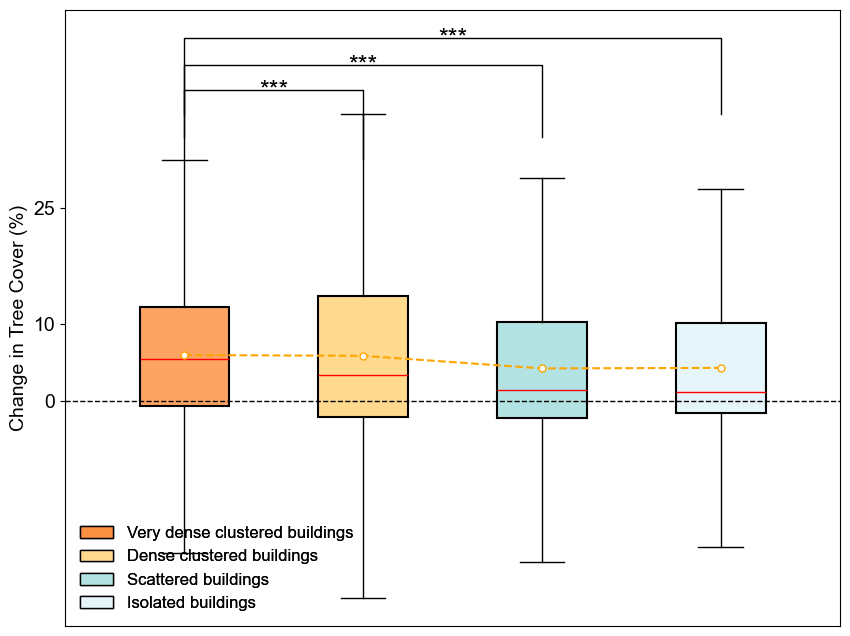

high_vs_low
high_vs_singe
high_vs_isloated


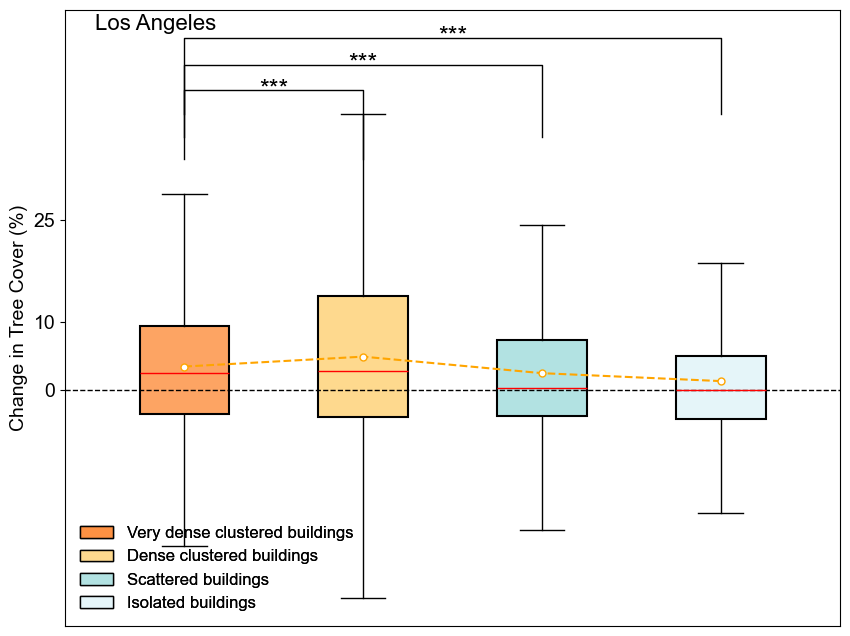

high_vs_low
high_vs_singe
high_vs_isloated


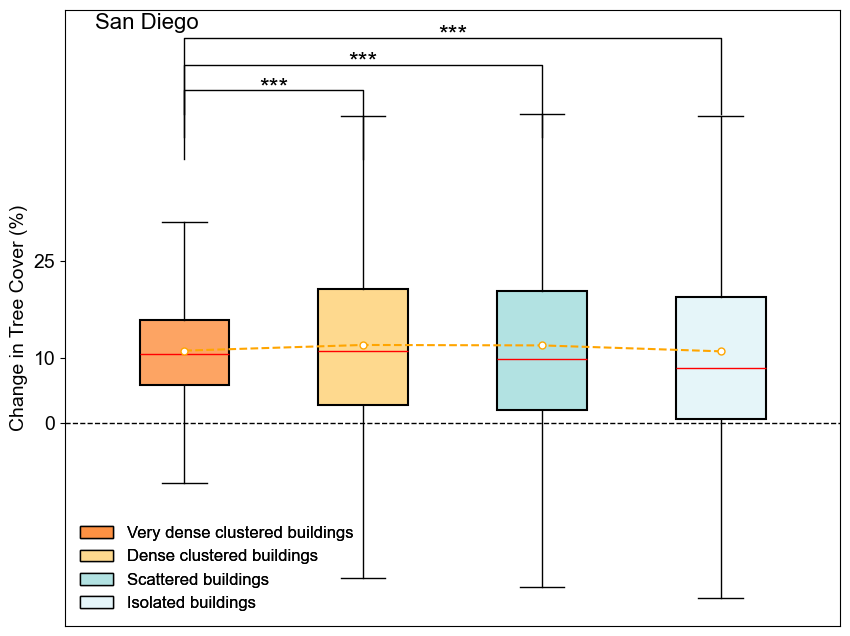

In [24]:

def plot_oldtreecoverchange(df,fp):
    if fp=='All':
        df1=df.query('newhouse==0')
    else:
        df1=df.query('newhouse==0 and COUNTY in [@fp]')
    df1['treeratiochange']*=100
    plotdensity(
        df1.query('housingclass =="very dense"'),
        df1.query('housingclass=="dense"'),
        df1.query('housingclass=="scattered"'),
        df1.query('housingclass=="isolated"'),
        add0=1,nc=1,tag='old',fp=fp)
plot_oldtreecoverchange(sbufferjoinhousefhsz,"All")
plot_oldtreecoverchange(sbufferjoinhousefhsz,"Los Angeles")
plot_oldtreecoverchange(sbufferjoinhousefhsz,"San Diego")


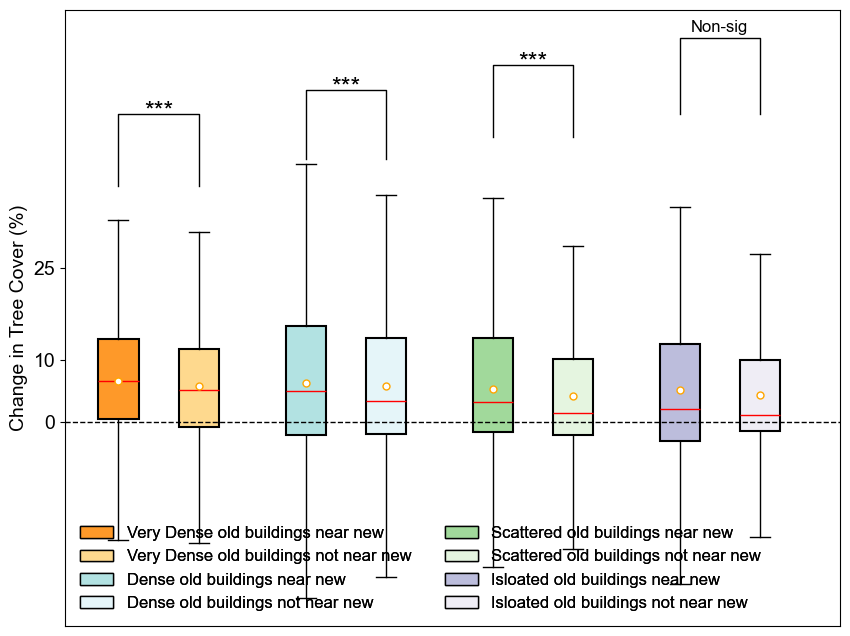

In [26]:
def plot_oldnew(df):
    df1=df.query('newhouse==0')
    df1['treeratiochange']*=100
    plotoldhousesinandoutnew(
        df1.query('newhcount>0 and housingclass=="very dense"'),
        df1.query('newhcount==0 and housingclass=="very dense"'),
        
        df1.query('newhcount>0 and housingclass=="dense"'),
        df1.query('newhcount==0 and housingclass=="dense"'),
        
        df1.query('newhcount>0 and housingclass=="scattered"'),
        df1.query('newhcount==0 and housingclass=="scattered"'),
        
        df1.query('newhcount>0 and housingclass=="isolated"'),
        df1.query('newhcount==0 and housingclass=="isolated"'),
            
    add0=1,nc=2,tag='oldnew')
plot_oldnew(sbufferjoinhousefhsz)

## plot oldnearnew (verydensebycounty)

In [27]:

def annotate_pvaluebycounty(ax,tag,center1, center2, p_value):
    bottom, top = ax.get_ylim()
    if tag=='up':
        if center1==0 and center2==0.3:
            bottom,top=-0.05*10,1.05*25  
        if center1==0.7 and center2==1:
            bottom,top=-0.1*10,1*33
            
        if center1==1.4 and center2==1.7:
            bottom,top=-0.1*10,1*39
        if center1==2.1 and center2==2.4:
            bottom,top=-0.1*10,1*35
        if center1==2.8:
            bottom,top=-0.1*10,1*45
        if center1==3.5:
            bottom,top=-0.1*10,1*30
        yrange = (top - bottom)
        level = 0
        bar_height = (yrange * 0.08 * level) + top
        bar_tips = bar_height - (yrange * 0.13)

        text_height = bar_height + (yrange * 0.005)
        plt.plot(
                [center1,center1,center2,center2],
                [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k')
        if p_value < 0.001:
            text = '***'
        elif p_value < 0.01:
            text = '**'
        elif p_value < 0.05:
            text = '*'
        else:
            text = 'Non-sig'  # Non-significant
        if text=='Non-sig':
            ax.text((center1 + center2) *0.5, text_height, text, ha='center', va='bottom', color='k',fontsize=10,fontweight='bold')
        
        else:
            ax.text((center1 + center2) *0.5, text_height-3, text, ha='center', va='bottom', color='k',fontsize=18,fontweight='bold')
    if tag=='down':
        if center1==0.7 or 2.1:
            bottom=-25
            top=10
        else:
            bottom=-15
            top=5
        yrange = -top+bottom
        level = 0
        bar_height =bottom
        bar_tips = bar_height

        text_height = bar_height-(yrange * 0.005)
        plt.plot(
                [center1,center1,center2,center2],
                [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k')
        if center1==0 :
            text='Ventura'
        if center1==0.7 :
            text='Los Angeles'
        if center1==1.4 :
            text='Orange'
        if center1==2.8 :
            text='San Bernardino'
        if center1==3.5 :
            text='Riverside'
        if center1==2.1 :
            text='San Diego'
        ax.text((center1 + center2) *0.5, text_height-4, text, ha='center', va='bottom', color='k',fontsize=11,fontweight='bold')
        
    return 0
       

def plot_oldwithnewverydense(data_dict, add0, figsize=(10, 8), p_values=1):
    fig, ax = plt.subplots(figsize=figsize)
    boxes = []
    positions = [0, 0.3, 0.7, 1, 1.4, 1.7, 2.1, 2.4,2.8,3.1,3.5,3.8]
    colors = ['#a1d99b', '#e5f5e0','#a1d99b', '#e5f5e0','#a1d99b', '#e5f5e0','#a1d99b', '#e5f5e0','#a1d99b', '#e5f5e0','#a1d99b', '#e5f5e0']
    for name, data_tuple in data_dict.items():
        for data, pos, color in zip(data_tuple, positions, colors):
            box = create_singleboxplot(data, pos, color)
            if pos in [0, 0.3]:
                boxes.append(box)
    
    # P-values annotations
    pos_pairs = {0: (0, 0.3), 2: (0.7, 1), 4: (1.4, 1.7), 6: (2.1, 2.4),
                 8: (2.8, 3.1), 10: (3.5, 3.8)}          
    for key, value in p_values.items():
        p_val, (idx1, idx2) = value
        if idx1 in pos_pairs:
            center1, center2 = pos_pairs[idx1]
            annotate_pvaluebycounty(ax, 'up', center1, center2, p_val)
            annotate_pvaluebycounty(ax, 'down', center1, center2, p_val)
    
    plt.yticks([-30, 0, 10, 25, 45], fontsize=14)
    
    # 添加虚线0
    if add0:
        plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
    # 设置x轴标签
    ax.set_xticks([])  
    plt.ylabel('Change in Tree Cover (%)',fontsize=12,weight='bold') #Ratio of tree cover change
    bottom, top = ax.get_ylim()
    plt.xlim(-0.2,4)
    plt.ylim(bottom,top+3)
    plt.yticks([0, 10,25],fontsize=12) 
    custom_palette = {
            'Very dense old buildings near new': '#a1d99b',  
            'Very dense old buildings not near new': '#e5f5e0'}
    legend_elements = [Patch(facecolor=color, edgecolor='black', label=name)
                      for name, color in custom_palette.items()]
    plt.legend(handles=legend_elements, 
                            loc='upper left',
                            bbox_to_anchor=None,
                            framealpha=0,
                            alignment='left',
                            fontsize=12,ncol=1)
    return plt



def plot_oldhousesinandoutnew_bycounty(df1in,df1out,df2in,df2out,df3in,df3out,df4in,df4out,df5in,df5out,df6in,df6out,add0):
    data_dict = {
        'Tree': (df1in['treeratiochange'],df1out['treeratiochange'],df2in['treeratiochange'],df2out['treeratiochange'],
                df3in['treeratiochange'],df3out['treeratiochange'],df4in['treeratiochange'],df4out['treeratiochange'],
                df5in['treeratiochange'],df5out['treeratiochange'],df6in['treeratiochange'],df6out['treeratiochange'])}

    
    p_values={}
    u_stat, p_val = stats.mannwhitneyu(df1in['treeratiochange'], df1out['treeratiochange'])
    p_values['highinouturban'] = (p_val, (0, 1))
    u_stat, p_val = stats.mannwhitneyu(df2in['treeratiochange'], df2out['treeratiochange']) 
    p_values['lowinouturban'] = (p_val, (2, 3))
    u_stat, p_val = stats.mannwhitneyu(df3in['treeratiochange'], df3out['treeratiochange']) 
    p_values['lowinouturban1'] = (p_val, (4, 5 ))
    u_stat, p_val = stats.mannwhitneyu(df4in['treeratiochange'], df4out['treeratiochange']) 
    p_values['lowinouturban2'] = (p_val, (6,7))
    u_stat, p_val = stats.mannwhitneyu(df5in['treeratiochange'], df5out['treeratiochange']) 
    p_values['lowinouturban21'] = (p_val, (8,9))
    u_stat, p_val = stats.mannwhitneyu(df6in['treeratiochange'], df6out['treeratiochange']) 
    p_values['lowinouturban211'] = (p_val, (10,11))
   
    fig = plot_oldwithnewverydense(data_dict,add0,figsize=(8, 6),p_values=p_values)
    
    plt.show()


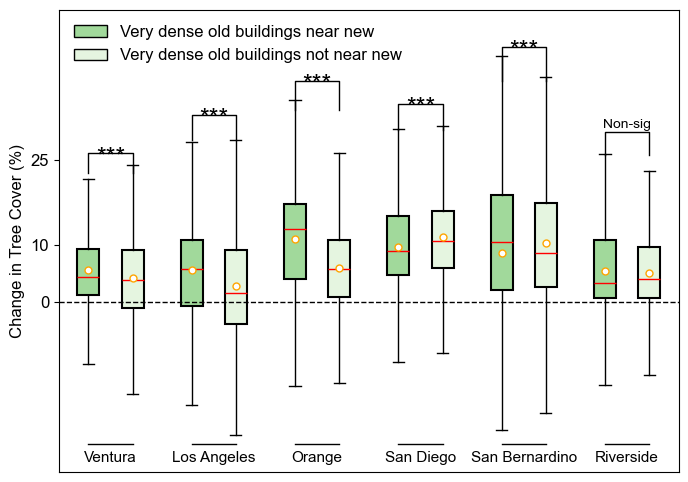

In [28]:

def plot_verydenseoldnew(df):
    df1=df.query('newhouse==0')
    df1['treeratiochange']*=100
   
    dfoldverydensenearnew=df1.query('newhcount>0 and housingclass=="very dense"')
    dfoldverydensenonew=df1.query('newhcount==0 and housingclass=="very dense"')
    plot_oldhousesinandoutnew_bycounty(
        dfoldverydensenearnew.query('COUNTYFP in ["111"]'),dfoldverydensenonew.query('COUNTYFP in ["111"]'),
        dfoldverydensenearnew.query('COUNTYFP in ["037"]'),dfoldverydensenonew.query('COUNTYFP in ["037"]'),
        dfoldverydensenearnew.query('COUNTYFP in ["059"]'),dfoldverydensenonew.query('COUNTYFP in ["059"]'),
        dfoldverydensenearnew.query('COUNTYFP in ["073"]'),dfoldverydensenonew.query('COUNTYFP in ["073"]'),
        dfoldverydensenearnew.query('COUNTYFP in ["071"]'),dfoldverydensenonew.query('COUNTYFP in ["071"]'),
        dfoldverydensenearnew.query('COUNTYFP in ["065"]'),dfoldverydensenonew.query('COUNTYFP in ["065"]'),add0=1)

plot_verydenseoldnew(sbufferjoinhousefhsz)

In [ ]:
## very dense cluster new old ratio
def cal_oldnewratioverydense(df):
    df['oldcount']=df['allhcount']-df['newhcount']
    ## The number of newhouse within very dense cluster
    newcount=df.query('newhouse==1 and newhcount>0 and oldcount>0 and housingclass=="very dense"').groupby(['COUNTY','housingclass']).size().to_frame('newcount')
    ## The number of oldhouse within very dense cluster
    oldcount=df.query('newhouse==0 and newhcount>0 and housingclass=="very dense"').groupby(['COUNTY','housingclass']).size().to_frame('oldcount')
    
    oldnewcount=oldcount.merge(newcount,on=['COUNTY','housingclass'],how='left')
    oldnewcount['newoldratio']=oldnewcount['newcount']/oldnewcount['oldcount']
    # oldnewcount.to_csv('../statistic/table/newfhsz/oldwithnewratioverydense.csv')
    print(oldnewcount)
cal_oldnewratioverydense(sbufferjoinhousefhsz)

                              oldcount  newcount  newoldratio
COUNTY          housingclass                                 
Kern            very dense        1537        89         0.06
Los Angeles     very dense       36375      2821         0.08
Orange          very dense        6661       200         0.03
Riverside       very dense        5002      1083         0.22
San Bernardino  very dense       10292      1418         0.14
San Diego       very dense       11316      2268         0.20
San Luis Obispo very dense        1212        49         0.04
Santa Barbara   very dense        1384       259         0.19
Ventura         very dense        5352       547         0.10


# Tree cover change----national forest boundary

In [5]:
sbufferjoinhousefhsz.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [4]:
sbufferjoinhousefhsz.columns

Index(['FID_Califo', 'WUICLASS_2', 'WUIFLAG202', 'GEOID', 'FHSZ_7Clas',
       'COUNTYFP', 'geometry', 'newhouse', 'cluster15', 'cluster50',
       'allhousecountbybuffer50', 'allhousecountbybuffer15', 'housingclass',
       'areaall2010', 'areabare2010', 'areagrass2010', 'areatree2010',
       'areaurban2010', 'cluster2010', 'cluster2022', 'areaall2022',
       'areatree2022', 'allhcount', 'newhcount', 'treeratio2010',
       'treeratio2022', 'treeratiochange', 'COUNTY'],
      dtype='object')

In [6]:
def groupbuilding_bydistanceto_nf(gdfhouse, nf):
    # CRS matches
    gdfhouse = gdfhouse.to_crs(nf.crs)  
    # Define buffer distances in meters (0 to 10km)
    buffer_distances = [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
    distance_labels = ['Inside'] + [f'{i}-{i+1}km' for i in range(0, 10)]
    
    # Temporary column to track buffer assignment
    gdfhouse['distance_group'] = None
    
    # Iterate through buffers from smallest to largest
    for i, dist in enumerate(buffer_distances):
        if i == 0:
            # Buildings inside NF (0km buffer)
            buffer_gdf = nf.copy()
            buffer_gdf['buffer_key'] = 1
        else:
            # Create buffer for current distance
            buffer = nf.buffer(dist)
          
            buffer_gdf = gpd.GeoDataFrame(geometry=buffer, crs=nf.crs)
            buffer_gdf['buffer_key'] = 1
        
        # Spatial join with buildings not yet assigned
        temp_join = gpd.sjoin(
            gdfhouse[gdfhouse['distance_group'].isna()],
            buffer_gdf[['geometry', 'buffer_key']],
            how='left',
            predicate='within'
        )
        
        # Assign distance group only to buildings that haven't been assigned yet
        mask = temp_join['buffer_key'] == 1
        gdfhouse.loc[temp_join[mask].index, 'distance_group'] = distance_labels[i]
    
    # Buildings beyond 10km
    gdfhouse['distance_group'] = gdfhouse['distance_group'].fillna('>10km')
    
    return gdfhouse

nf=gpd.read_file('../Data/nf.gpkg').to_crs(epsg=5070)
sbufferjoinhousefhsz = groupbuilding_bydistanceto_nf(sbufferjoinhousefhsz, nf)

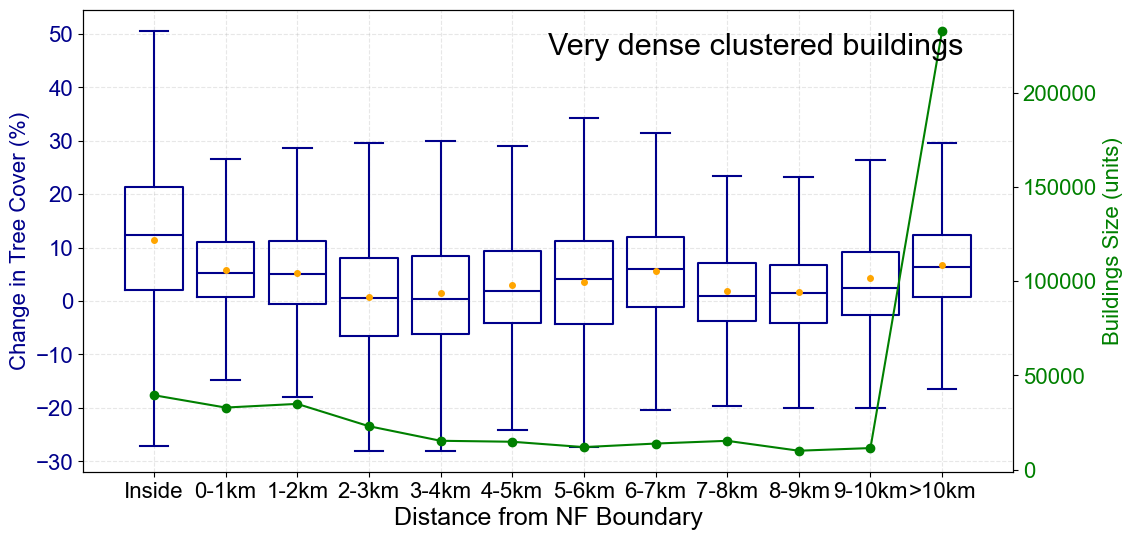

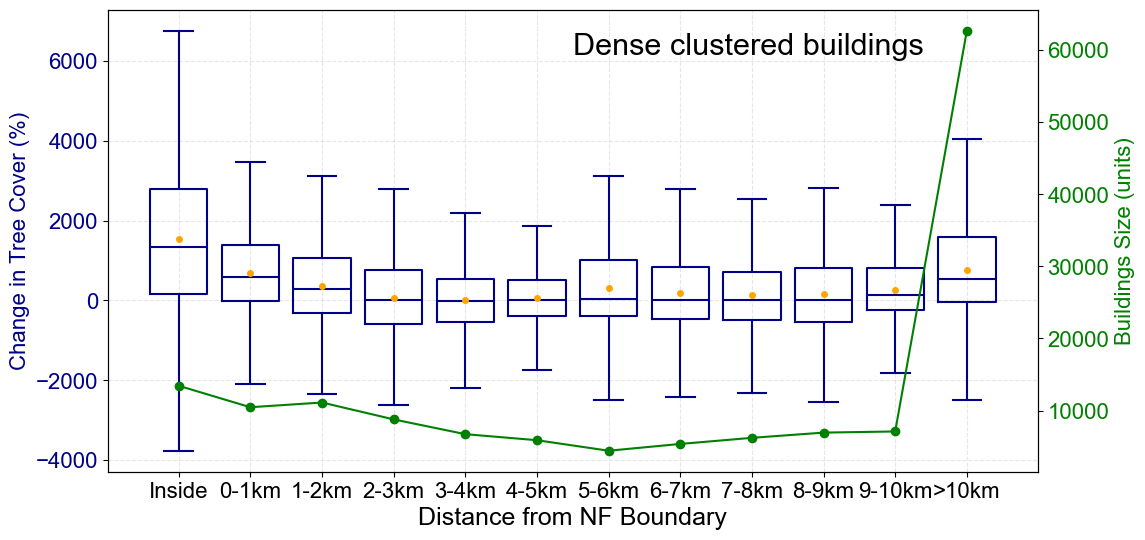

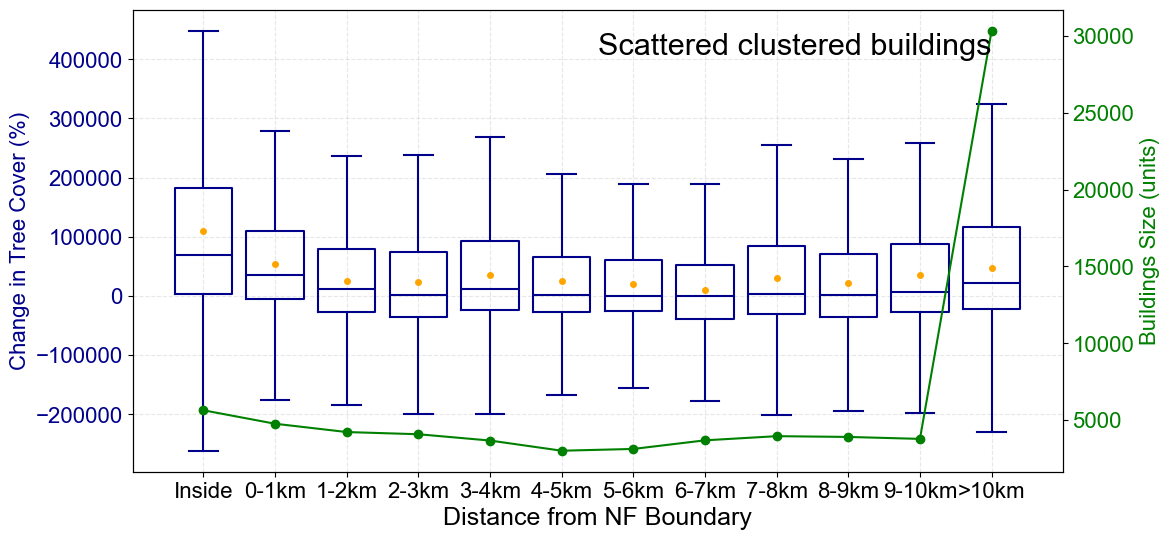

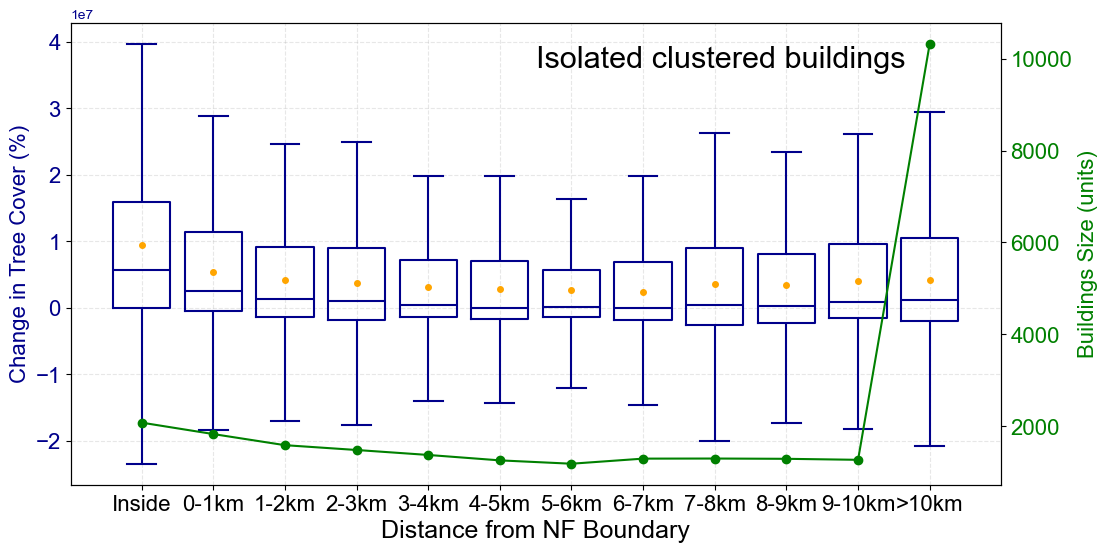

In [7]:
def plot_treecoverbynf(df,housingtype,text):
    df['treeratiochange']*=100
    df1=df.query("newhouse==0 and housingclass in @housingtype")
    # Calculate sample sizes for each distance group
    sample_sizes = df1['distance_group'].value_counts().reindex(
        ['Inside'] + [f'{i}-{i+1}km' for i in range(0, 10)]+[">10km"], fill_value=0
    )
    # print(f'{text},within10km/beyond10km:',len(df1.query('distance_group not in [">10km"]'))/len(df1.query('distance_group  in [">10km"]')))

    # Create figure and twin axes
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()  # Second y-axis

    # Boxplot on the left y-axis (ax1)
    sns.boxplot(
        x='distance_group',
        y='treeratiochange',
        data=df1,
        color='darkblue',
        fill=False,
        order=['Inside'] + [f'{i}-{i+1}km' for i in range(0, 10)]+[">10km"],
        linewidth=1.5,
        showmeans=True,
        showfliers=False,
        flierprops={'marker': 'o', 'markersize': 5, 'markerfacecolor': 'red', 'markeredgecolor': 'red'},
        ax=ax1,
        meanprops={  
            'marker': 'o',       
            'markerfacecolor': 'orange',  # Orange fill color
            'markeredgecolor': 'orange',  # Orange edge color (optional)
            'markersize': 4    
        }
    )

    # Sample size curve on the right y-axis (ax2)
    ax2.plot(
        sample_sizes.index,
        sample_sizes.values,
        color='green',
        linestyle='-', 
        marker='o',
        markersize=6,
        label='Buildings Size (units)',
        
    )

    # Customize ax1 (left y-axis - boxplot)
    # ax1.set_title('Tree Cover Change and Sample Size by Distance from NF Boundary', fontsize=14, pad=15)
    ax1.set_xlabel('Distance from NF Boundary', fontsize=18)
    ax1.set_ylabel('Change in Tree Cover (%)', fontsize=16, color='darkblue')
    ax1.tick_params(axis='y', labelcolor='darkblue', labelsize=16)
    ax1.grid(True, linestyle='--', alpha=0.3)
    ax1.set_xticks(range(len(sample_sizes.index)))
    ax1.set_xticklabels(sample_sizes.index, rotation=0, fontsize=16)

    # Customize ax2 (right y-axis - sample size curve)
    ax2.set_ylabel('Buildings Size (units)', fontsize=16, color='green')
    ax2.tick_params(axis='y', labelcolor='green',labelsize=16)
    plt.text(0.5, 0.95, text, transform=plt.gca().transAxes, fontsize=22, verticalalignment='top')
    # plt.tight_layout()

    # plt.show()

plot_treecoverbynf(sbufferjoinhousefhsz,['very dense'],'Very dense clustered buildings')
plot_treecoverbynf(sbufferjoinhousefhsz,['dense'],'Dense clustered buildings')
plot_treecoverbynf(sbufferjoinhousefhsz,['scattered'],'Scattered clustered buildings')
plot_treecoverbynf(sbufferjoinhousefhsz,['isolated'],'Isolated clustered buildings')